In [1]:
!pip install -U -q transformers qwen_vl_utils datasets torch unsloth trl bitsandbytes bert_score accelerate 
!pip install  -U -q git+https://github.com/huggingface/transformers.git

In [2]:
import os
import io
import gc
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
import torchvision.transforms as T
from datasets import load_dataset, DatasetDict
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor, \
                         EarlyStoppingCallback, BitsAndBytesConfig, TrainerCallback
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig, get_peft_model, PeftModel
from qwen_vl_utils import process_vision_info
from huggingface_hub import login

import warnings
warnings.filterwarnings("ignore")

HF_API_KEY = "xxx"
login(token=HF_API_KEY)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Add to prevent issues
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

#model_name = "unsloth/Llama-3.2-11B-Vision-Instruct"
#model_name = "Qwen/Qwen2.5-VL-7B-Instruct"
model_name = "Qwen/Qwen2.5-VL-3B-Instruct"

max_length = 2048

print(f"Using device: {device}")

Using device: cuda


In [4]:
dataset = load_dataset("mmoukouba/MedPix-Grouped-QA")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'questions', 'answers'],
        num_rows: 2050
    })
})

In [5]:
# Split the data into train, validation, and test sets
dataset = dataset.shuffle(seed=42)  # Ensure dataset is shuffled before splitting

# Apply train-test split on `dataset["train"]` instead of the entire DatasetDict
split_dataset = dataset["train"].train_test_split(test_size=0.2)  # 80% train & 20% test+valid

# Further split the test set into validation and test (95% valid, 5% test)
test_valid_split = split_dataset["test"].train_test_split(test_size=0.05)  # 95% valid & 5% test

# Create the final DatasetDict
final_dataset = DatasetDict({
    "train": split_dataset["train"],
    "valid": test_valid_split["train"],
    "test": test_valid_split["test"]
})

print(final_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'questions', 'answers'],
        num_rows: 1640
    })
    valid: Dataset({
        features: ['image', 'questions', 'answers'],
        num_rows: 389
    })
    test: Dataset({
        features: ['image', 'questions', 'answers'],
        num_rows: 21
    })
})


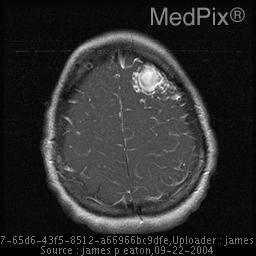

In [6]:
example = final_dataset['train'][0]
image = example["image"]
image

In [8]:
def format_data(sample):
    sample["image"] = sample["image"].convert("RGB")
    conversation = [
        {
            "role": "user",
            "content": [{"type": "image", "image": sample["image"]}],
        }
    ]

    # Iterate through the multi-turn Q&A
    for question, answer in zip(sample["questions"], sample["answers"]):
        conversation.append({
            "role": "user",
            "content": [{"type": "text", "text": question}],
        })
        conversation.append({
            "role": "assistant",
            "content": [{"type": "text", "text": answer}],
        })

    return conversation


train_dataset = [format_data(sample) for sample in final_dataset["train"]]
eval_dataset = [format_data(sample) for sample in final_dataset["valid"]]
test_dataset = [format_data(sample) for sample in final_dataset["test"]]

print(len(train_dataset))
print("-*-*"*32)
print(train_dataset[0])
print("-*-*"*32)
print(len(eval_dataset))
print("-*-*"*32)
print(eval_dataset[0])

1640
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=256x256 at 0x7F4736242CE0>}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'What is the likely cause of sudden loss of consciousness in a 26-year-old female patient?'}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'The likely cause of sudden loss of consciousness in this patient is an arteriovenous malformation (AVM) rupture, given her symptoms and the imaging findings.'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': "How is this patient's AVM diagnosed and treated?"}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': "This patient's AVM is diagnosed using angiography with glueing followed by surgery. She undergoes three sessions of angiography with glueing of the feeding arteries and then surgical resection of the

torch.Size([3, 256, 256])


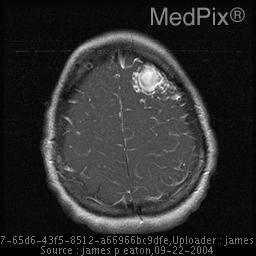

In [9]:
image = train_dataset[0][0]["content"][0]["image"]

to_tensor = transforms.ToTensor()
image_tensor = to_tensor(image)
print(image_tensor.shape)
image

In [10]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
     model_name,
     torch_dtype="auto",
     device_map="auto",
     quantization_config=bnb_config,
)

processor = AutoProcessor.from_pretrained(model_name, use_fast=True)

processor.tokenizer.pad_token = processor.tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",]

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)


args = SFTConfig(
    output_dir="MedPix_Qwen2-5_3b",         # directory to save and repository id
    num_train_epochs=1,                     # number of training epochs
    per_device_train_batch_size=2,          # batch size per device during training
    per_device_eval_batch_size=2,           # batch size per device during validation
    gradient_accumulation_steps=4,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=5,                        # log every 5 steps
    save_strategy="steps",                  # save checkpoint every certain steps
    eval_strategy="steps",                  # evaluation strategy set to steps
    save_total_limit=1,                     # save only 1 checkpoint
    save_steps=200,                         # save model every 200 steps
    eval_steps=20,                          # evaluate model every 50 steps
    metric_for_best_model="eval_loss",      # monitor eval_loss for best model
    load_best_model_at_end=True,            # load the best model at the end of training
    learning_rate=2e-4,                     # learning rate based on QLoRA paper
    lr_scheduler_type="cosine",             # cosine scheduler for gradual LR decay
    bf16=True,                              # use bfloat16 precision
    tf32=False,                             # disable tf32 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio for learning rate scheduler
    push_to_hub=True,                       # push model to hub
    logging_dir="./logs",                   # logging directory for TensorBoard
    report_to="tensorboard",                # report metrics to tensorboard
    gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
    dataset_text_field="",                  # dummy field for collator
    dataset_kwargs = {"skip_prepare_dataset": True} # important for collator
)

args.remove_unused_columns=False

peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 18,576,384 || all params: 3,773,199,360 || trainable%: 0.4923


In [12]:
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [processor.apply_chat_template(example, tokenize=False, add_generation_prompt=False) for example in examples]
    image_inputs = [process_vision_info(example)[0] for example in examples]

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding="longest")

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  #
    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2_5_VLProcessor):
        image_tokens = [151652,151653,151655]
    else: 
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100
    batch["labels"] = labels

    #print(batch["input_ids"].shape)
    #print(batch["pixel_values"].shape)

    return batch
    

collate_sample = [train_dataset[0], train_dataset[1], train_dataset[2], train_dataset[3]] # for batch size 4.

collated_data = collate_fn(collate_sample)
print(collated_data.keys())

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw', 'labels'])


In [13]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,  
    early_stopping_threshold=0.01,  
    monitor="eval_loss"  
)


class CustomCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            print(f"Step {state.global_step}: loss = {logs['loss']:.4f}")


trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    tokenizer=processor.tokenizer,
     callbacks=[CustomCallback(), early_stopping],
)


model.config.use_cache = False

print("Training")
trainer.train()
print("-"*32)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Training


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
20,1.441200,1.369650
40,1.254900,1.248116
60,1.208500,1.212798
80,1.180400,1.193426
100,1.181000,1.176157
120,1.106800,1.164408
140,1.163200,1.154652
160,1.131100,1.148633
180,1.140800,1.145243
200,1.119900,1.144623


Step 5: loss = 1.8685
Step 10: loss = 1.5951
Step 15: loss = 1.4969
Step 20: loss = 1.4412
Step 25: loss = 1.3163
Step 30: loss = 1.3412
Step 35: loss = 1.2967
Step 40: loss = 1.2549
Step 45: loss = 1.2388
Step 50: loss = 1.2649
Step 55: loss = 1.1804
Step 60: loss = 1.2085
Step 65: loss = 1.2008
Step 70: loss = 1.1801
Step 75: loss = 1.1925
Step 80: loss = 1.1804
Step 85: loss = 1.1992
Step 90: loss = 1.1901
Step 95: loss = 1.2349
Step 100: loss = 1.1810
Step 105: loss = 1.1613
Step 110: loss = 1.1775
Step 115: loss = 1.1776
Step 120: loss = 1.1068
Step 125: loss = 1.1288
Step 130: loss = 1.1094
Step 135: loss = 1.1440
Step 140: loss = 1.1632
Step 145: loss = 1.1301
Step 150: loss = 1.0535
Step 155: loss = 1.1814
Step 160: loss = 1.1311
Step 165: loss = 1.0869
Step 170: loss = 1.1622
Step 175: loss = 1.1396
Step 180: loss = 1.1408
Step 185: loss = 1.1688
Step 190: loss = 1.1495
Step 195: loss = 1.1450
Step 200: loss = 1.1199
Step 205: loss = 1.1235
--------------------------------


In [14]:
# 1. Set the base model and your LoRA adapter path
model_name = "Qwen/Qwen2.5-VL-3B-Instruct"   # ✅ The original base model
lora_path = "MedPix_Qwen2-5_3b"              # ✅ Your LoRA fine-tuned weights
save_path = "MedPix_Qwen2-5_3b-merged"       # ✅ Final merged model output path

# 2. Load the base model (full model)
base_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16  # or torch.float16 if you trained in fp16
)

# 3. Load and merge the LoRA adapter
model = PeftModel.from_pretrained(base_model, lora_path)
merged_model = model.merge_and_unload()

# 4. Save the merged model
merged_model.save_pretrained(save_path)

# 5. Save processor and tokenizer
processor = AutoProcessor.from_pretrained(model_name, use_fast=True)
processor.save_pretrained(save_path)
processor.tokenizer.save_pretrained(save_path)

print("✅ Merged model saved at:", save_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Merged model saved at: MedPix_Qwen2-5_3b-merged


In [15]:
from transformers import GenerationConfig

# Ensure generation_config is saved
gen_config = GenerationConfig.from_model_config(merged_model.config)
merged_model.generation_config = gen_config

# Optionally fix decoder_config if needed (for VL or encoder-decoder models)
if hasattr(merged_model.config, "decoder_config") and isinstance(merged_model.config.decoder_config, dict):
    from transformers import AutoConfig
    arch = merged_model.config.architectures[0] if merged_model.config.architectures else "Qwen2_5_VLForConditionalGeneration"
    merged_model.config.decoder_config = AutoConfig.for_model(arch).from_dict(merged_model.config.decoder_config)

# Now push everything to HuggingFace
merged_model.push_to_hub("mmoukouba/Qwen2.5-VL-3B-MedPix-VQA")
processor.tokenizer.push_to_hub("mmoukouba/Qwen2.5-VL-3B-MedPix-VQA")
processor.push_to_hub("mmoukouba/Qwen2.5-VL-3B-MedPix-VQA")
gen_config.push_to_hub("mmoukouba/Qwen2.5-VL-3B-MedPix-VQA") 

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.51G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mmoukouba/MedPix_Qwen2-5_3b-finetuned/commit/d251a64903b5ebc737b4ea200083b759a5f53e25', commit_message='Upload processor', commit_description='', oid='d251a64903b5ebc737b4ea200083b759a5f53e25', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mmoukouba/MedPix_Qwen2-5_3b-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='mmoukouba/MedPix_Qwen2-5_3b-finetuned'), pr_revision=None, pr_num=None)